# Spatial-DC: a robust deep learning-based method for deconvolution of spatial proteomics
The demo analysis workflow and source code for deconvolution of synthetic spatial proteomics data by Spatial-DC, is described below.

[![python >3.9.20](https://img.shields.io/badge/python-3.9.20-brightgreen)](https://www.python.org/)

<p align="center">
  <img width="100%" src=simulations.jpg>
</p>

<p align="center"><strong>The typical framework of generating synthetic spatial proteomics data. </strong></p>

## Here is a demo code on python envirment to the assessment of Spatial-DC on synthetic NSCLC data.

In [112]:
# Load necessary packages
import os
import sys
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
from scipy import stats
# import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings("ignore")

print(sys.version)
# plt.rcParams['font.size'] = 10
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

3.9.20 | packaged by conda-forge | (main, Sep 30 2024, 17:49:10) 
[GCC 13.3.0]


In [113]:
# set the working directory
os.chdir("Spatial_DC")
dataset_dir = "datasets/NSCLC/synthetic_noise_levels"
scaler = MinMaxScaler(feature_range=(0, 1))

## Overview of reference data and spatial proteomics data.

In [114]:
# Overview the reference proteomics data
sc_adata = sc.read_h5ad(f"{dataset_dir}/reference_proteomics_noise/reference_noise0.h5ad")
ct_order = ["C10","RAW","SVEC"] # define the order of cell types

print(f"Protein intensity: {sc_adata.to_df().iloc[0:4,0:4]}\n")
print(f"The number of cells: {sc_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", sc_adata.shape)

Protein intensity: pid             B2RQC6       D3YXK2       D3Z7P3       E9Q555
SampleID                                                     
Cell1     10199.681641  1206.335083  3252.627686  7920.826172
Cell2      7663.400879  1475.635010  4225.516602  7812.691895
Cell3     11032.712891  1869.883545  3676.055664  6762.318359
Cell4      8994.453125  1951.975586  3811.925049  5835.416992

The number of cells: celltype
C10     36
RAW     36
SVEC    36
Name: count, dtype: int64

The total cells and intersected proteins: (108, 1003)


In [115]:
# Overview the spatial proteomics data (with spot size of 100 μm)
sp_adata = sc.read_h5ad(f"{dataset_dir}/spatial_proteomics_spotsize_noise/spatial_spotsize200_noise0.h5ad")
print(f"Protein intensity: {sp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", sp_adata.shape)

Protein intensity:           B2RQC6     D3YXK2    D3Z7P3     E9Q555
spot_1  8.404799  38.643871  9.023991  73.154076
spot_2  4.854225  28.182434  6.060483  47.099457
spot_3  6.620897  31.050787  6.776834  58.355949
spot_4  6.845562  37.577995  8.321666  65.452919

The total spots and intersected proteins: (495, 1003)


In [116]:
sp_adata.uns["celltype_gd"]

,C10,RAW,SVEC
spot_1,0.000000,0.095238,0.904762
spot_2,0.000000,0.444444,0.555556
spot_3,0.605263,0.078947,0.315789
spot_4,0.268293,0.219512,0.512195
spot_5,0.072727,0.400000,0.527273
...,...,...,...
spot_491,0.000000,0.176471,0.823529
spot_492,0.000000,0.000000,1.000000
spot_493,0.000000,0.428571,0.571429
spot_494,0.058824,0.411765,0.529412


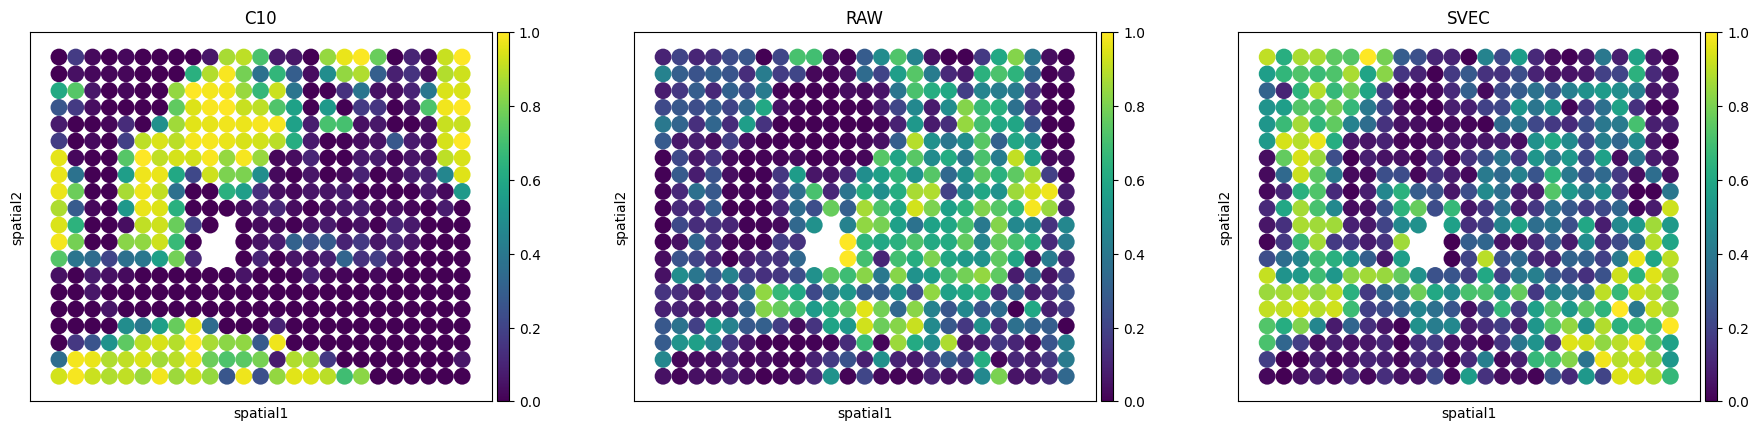

In [117]:
# Visualization of the ground truth of each cell type
sp_adata.obs = sp_adata.uns["celltype_gd"]
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order)

In [118]:
# Load Intersection of reference and spatial datasets
intersect = np.intersect1d(sc_adata.var_names, sp_adata.var_names)        
sp_adata = sp_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

sc.pp.normalize_total(sc_adata)
sc.pp.normalize_total(sp_adata)

## Create deconvolution model and load trained DIS model

In [119]:
# Load Spatial-DC package
from Spatial_DC_beta import SpatialDC

# conda install pytorch-cluster -c pyg

# Load trained DIS model
model_path = f"trained_model/NSCLC/synthetic_noise_levels/model_epoch200_noise0.pt"

spatial_dc = SpatialDC(sc_adata=sc_adata, sp_adata=sp_adata, print_info=True) 
spatial_dc.load_distribution_model(load_model_path = model_path)
pred_sp_adata = spatial_dc.transfer_distribution_model()

In [120]:
pred_sp_adata.uns["cellperc_initial"].iloc[0:4,0:4] # Overview of the intermediate cell percentages

,C10,RAW,SVEC
spot_1,0.000000,0.000000,1.000000
spot_2,0.000000,0.628809,0.371191
spot_3,0.638291,0.000000,0.361709
spot_4,0.243737,0.002747,0.753516


In [121]:
# Traine the self-supvervised model
spatial_dc.setup_reconstruction_model(k_graph=30, epochs=200)
refined_sp_adata = spatial_dc.reconstruct()

  [Epoch   1] Loss: 26.08889
  [Epoch   2] Loss: 23.09055
  [Epoch   3] Loss: 19.90976
  [Epoch   4] Loss: 18.29403
  [Epoch   5] Loss: 17.64634
  [Epoch   6] Loss: 16.94146
  [Epoch   7] Loss: 16.61508
  [Epoch   8] Loss: 16.28284
  [Epoch   9] Loss: 16.23770
  [Epoch  10] Loss: 15.99778
  [Epoch  11] Loss: 15.75920
  [Epoch  12] Loss: 15.63329
  [Epoch  13] Loss: 15.41747
  [Epoch  14] Loss: 15.26824
  [Epoch  15] Loss: 15.06962
  [Epoch  16] Loss: 14.91574
  [Epoch  17] Loss: 14.74067
  [Epoch  18] Loss: 14.48570
  [Epoch  19] Loss: 14.43331
  [Epoch  20] Loss: 14.29915
  [Epoch  21] Loss: 13.98155
  [Epoch  22] Loss: 13.86583
  [Epoch  23] Loss: 13.65742
  [Epoch  24] Loss: 13.55069
  [Epoch  25] Loss: 13.26546
  [Epoch  26] Loss: 13.15268
  [Epoch  27] Loss: 13.02194
  [Epoch  28] Loss: 12.67573
  [Epoch  29] Loss: 12.62956
  [Epoch  30] Loss: 12.26937
  [Epoch  31] Loss: 12.19069
  [Epoch  32] Loss: 11.99042
  [Epoch  33] Loss: 11.71615
  [Epoch  34] Loss: 11.51178
  [Epoch  35] 

In [122]:
# print the refined cell-type composition
pred_ct = pred_sp_adata[sp_adata.obs.index].uns["cellperc_reconstruct"][ct_order]
gd_ct = sp_adata.uns["celltype_gd"][ct_order]
print("Here is the predicted cell-type composition:")
print(pred_ct.iloc[0:10,0:4])
print("\n")
print("Here is the ground truth cell-type composition:")
print(gd_ct.iloc[0:10,0:4])

Here is the predicted cell-type composition:
              C10       RAW      SVEC
spot_1   0.000000  0.000000  1.000000
spot_2   0.000000  0.656622  0.343378
spot_3   0.667638  0.000000  0.332361
spot_4   0.239104  0.000000  0.760895
spot_5   0.000000  0.494138  0.505862
spot_6   0.038727  0.000000  0.961273
spot_7   1.000000  0.000000  0.000000
spot_8   1.000000  0.000000  0.000000
spot_9   1.000000  0.000000  0.000000
spot_10  1.000000  0.000000  0.000000


Here is the ground truth cell-type composition:
              C10       RAW      SVEC
spot_1   0.000000  0.095238  0.904762
spot_2   0.000000  0.444444  0.555556
spot_3   0.605263  0.078947  0.315789
spot_4   0.268293  0.219512  0.512195
spot_5   0.072727  0.400000  0.527273
spot_6   0.179487  0.282051  0.538462
spot_7   0.958824  0.005882  0.035294
spot_8   0.968553  0.006289  0.025157
spot_9   0.970588  0.009804  0.019608
spot_10  0.878571  0.007143  0.114286


Here is the ground truth cell-type composition


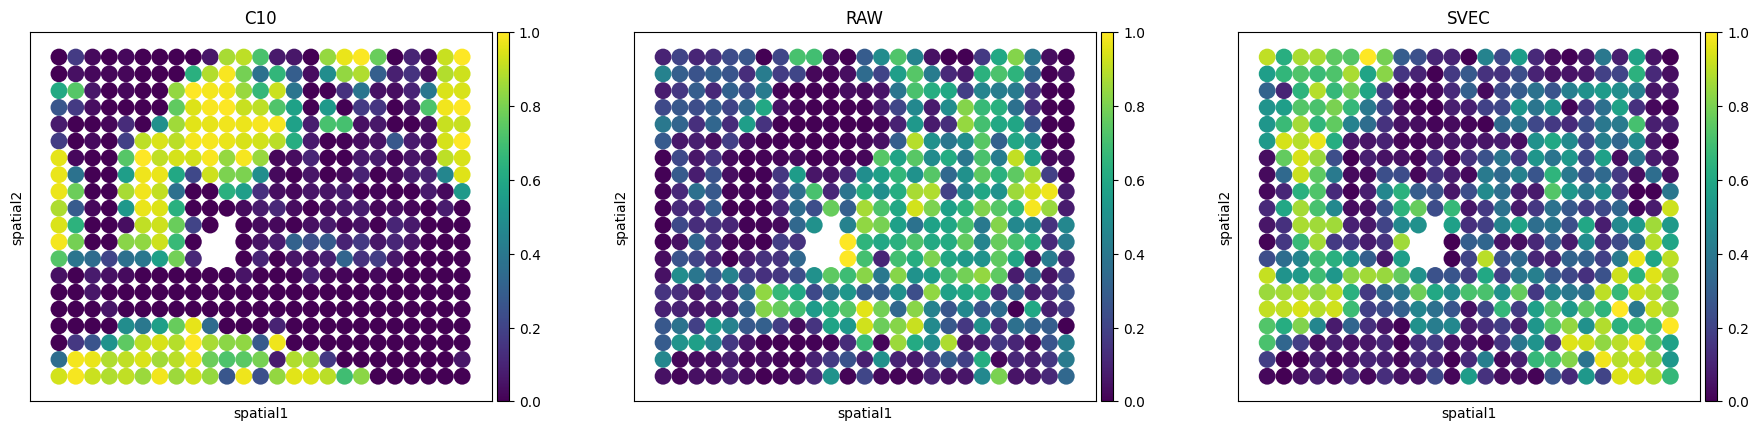

Here is the predicted cell-type composition


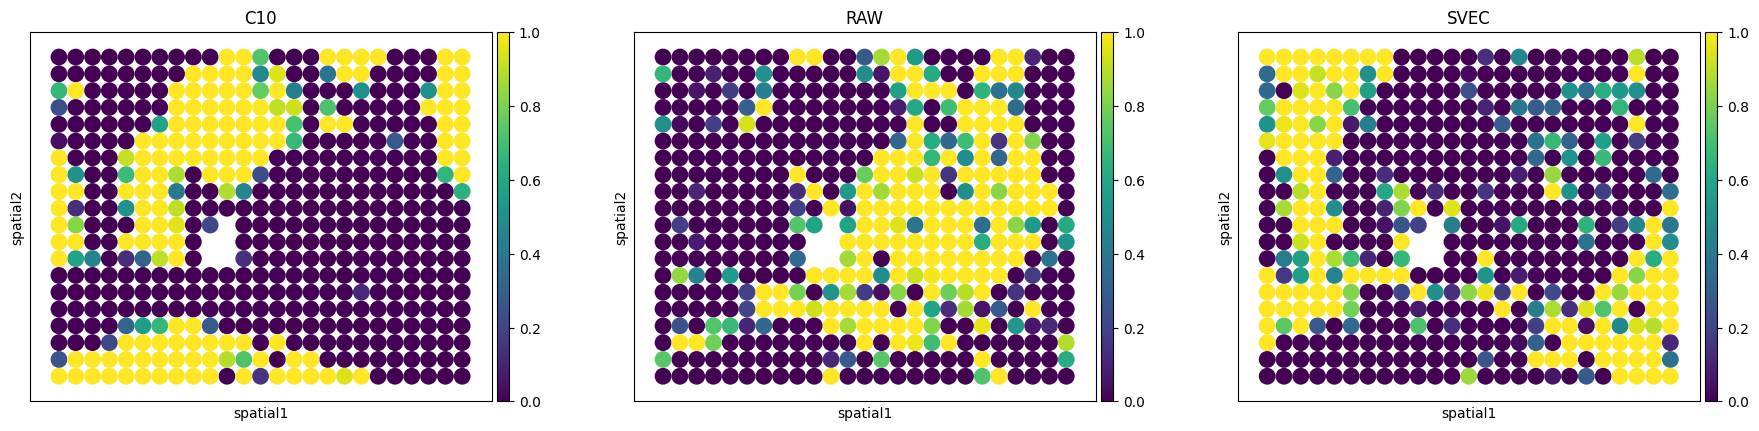

In [123]:
# Plot the distribution of predicted cell-type composition
print("Here is the ground truth cell-type composition")
sp_adata.obs = gd_ct[ct_order]
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,vmin=0,vmax=1)

sp_adata.obs = pred_ct[ct_order]
print("Here is the predicted cell-type composition")
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,vmin=0,vmax=1)

In [124]:
# Initialize lists to store results
results = []
def CCCscore(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    rho = np.corrcoef(x, y)[0][1]
    sd_x = np.std(x)
    sd_y = np.std(y)
    numerator = 2 * rho * sd_x * sd_y
    denominator = sd_x ** 2 + sd_y ** 2 + (x_mean - y_mean) ** 2
    ccc = numerator / denominator
    return ccc
 
# Calculate metrics for each cell type
for ct in ct_order:
    
    pcc = pearsonr(gd_ct[ct], pred_ct[ct])[0]        
    rmse = np.sqrt(np.mean((gd_ct[ct] - pred_ct[ct]) ** 2))        
    spcc = spearmanr(gd_ct[ct], pred_ct[ct])[0]    
    ccc = CCCscore(gd_ct[ct], pred_ct[ct])
    
    results.append({
        'cell type': ct,
        'PCC': pcc,
        'RMSE': rmse,
        'SPCC': spcc, 
        'CCC': ccc
    })
 
df_results = pd.DataFrame(results)
 
# Print the DataFrame
print("Performance evaluation of Spatial-DC:")
print(df_results)
 
# Calculate averages and print them
avg_metrics = df_results[['PCC', 'RMSE', 'SPCC', 'CCC']].mean()
print("\nThe average of the four metrics are:")
print(avg_metrics)

Performance evaluation of Spatial-DC:
  cell type       PCC      RMSE      SPCC       CCC
0       C10  0.980564  0.101792  0.867920  0.970593
1       RAW  0.932937  0.208491  0.912862  0.841820
2      SVEC  0.917944  0.194414  0.890330  0.860514

The average of the four metrics are:
PCC     0.943815
RMSE    0.168232
SPCC    0.890371
CCC     0.890976
dtype: float64


## Assessment of reconstructing cell-type proteomic profiles by Spatial-DC from representative synthetic NSCLC data

Protein intensity:                    B2RQC6        D3YXK2        D3Z7P3        E9Q555
ID                                                                 
spot_1_C10   3.809178e-22  3.039859e-22  1.916167e-22  1.204540e-22
spot_1_RAW   8.207467e-23  4.574156e-22  3.694359e-22  9.622864e-22
spot_1_SVEC  1.055975e+01  4.868870e+01  1.133130e+01  9.220511e+01
spot_2_C10   9.596216e-22  1.134547e-20  1.154885e-21  1.019403e-20

The total spots and intersected proteins: (1485, 1003)
The number of cells: celltype
C10     495
RAW     495
SVEC    495
Name: count, dtype: int64

The total cells and intersected proteins: (1485, 1003)


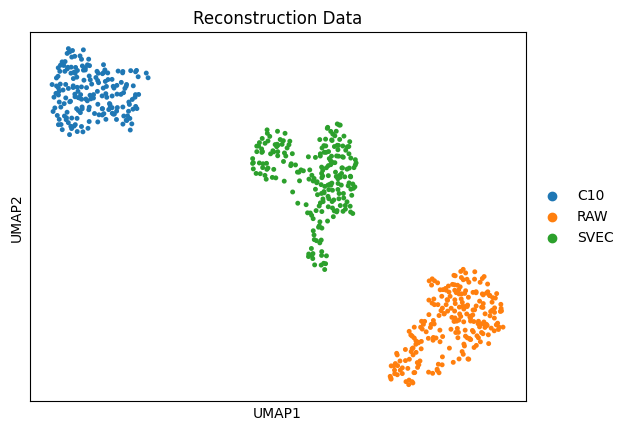

In [125]:
# Obtain the reconstructed adata from trained SSM
rec_scp_adata = spatial_dc.purify_spots(norm=True, spatial_info=True)

print(f"Protein intensity: {rec_scp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", rec_scp_adata.shape)

print(f"The number of cells: {rec_scp_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", rec_scp_adata.shape)

# UMAP of reconstructed adata
rec_scp_adata = rec_scp_adata[rec_scp_adata.obs["cellperc"] > 0,:]
sc.pp.filter_cells(rec_scp_adata, min_genes=10)
sc.pp.filter_genes(rec_scp_adata, min_cells=3)
rec_scp_adata.uns["raw"] = rec_scp_adata.X.copy()

sc.pp.normalize_total(rec_scp_adata)
sc.pp.log1p(rec_scp_adata)
sc.pp.scale(rec_scp_adata)
sc.pp.pca(rec_scp_adata)
sc.pp.neighbors(rec_scp_adata, n_neighbors=40, n_pcs=40)
sc.tl.umap(rec_scp_adata)
sc.pl.umap(rec_scp_adata, color=["celltype"], size=50, title="Reconstruction Data")

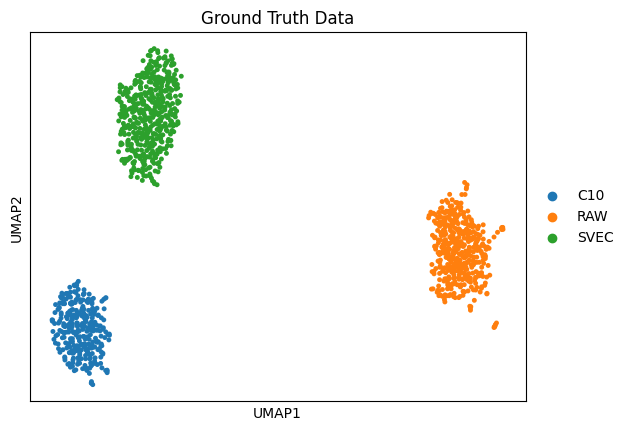

In [126]:
# gd adata
gd_scp_adata = sc.read_h5ad(f"datasets/NSCLC/synthetic_noise_levels/spatial_celltype_proteomics_spotsize_noise/spatial_celltype_spotsize200_noise0.h5ad")
gd_scp_adata = gd_scp_adata[gd_scp_adata.obs["cellperc"] > 0,:]
sc.pp.filter_cells(gd_scp_adata, min_genes=10)
sc.pp.filter_genes(gd_scp_adata, min_cells=3)

gd_scp_adata.uns["raw"] = gd_scp_adata.X.copy()

sc.pp.normalize_total(gd_scp_adata)
sc.pp.log1p(gd_scp_adata)
sc.pp.scale(gd_scp_adata)
sc.pp.pca(gd_scp_adata)
sc.pp.neighbors(gd_scp_adata, n_neighbors=40, n_pcs=40)
sc.tl.umap(gd_scp_adata)
sc.pl.umap(gd_scp_adata, color=["celltype"], size=50, title="Ground Truth Data")

In [127]:
# Calculate the PCC, SPCC and CCC for each celltype
ct_orders_list = []
total_pcc = []
total_spcc = [] 
total_ccc = [] 
total_rmse = []

rec_scp_adata.X = rec_scp_adata.uns["raw"].copy()
gd_scp_adata.X = gd_scp_adata.uns["raw"].copy()

# intersected
intersected_ct = np.intersect1d(gd_scp_adata.obs.index, rec_scp_adata.obs.index)
intersected_pid = np.intersect1d(gd_scp_adata.var_names, rec_scp_adata.var_names)

gd_scp_adata = gd_scp_adata[intersected_ct,intersected_pid].copy()
rec_scp_adata = rec_scp_adata[intersected_ct,intersected_pid].copy()

sc.pp.normalize_total(gd_scp_adata)
sc.pp.normalize_total(rec_scp_adata)
sc.pp.log1p(gd_scp_adata)
sc.pp.log1p(rec_scp_adata)

for i, ct in enumerate(ct_order):    
    pp = rec_scp_adata[rec_scp_adata.obs["celltype"] == ct].copy()
    gg = gd_scp_adata[gd_scp_adata.obs["celltype"] == ct].copy()
    
    for j,spot in enumerate(pp.obs.index):
        pp_j = np.array(pp.to_df().iloc[j])
        gg_j = np.array(gg.to_df().iloc[j])
        
        pcc = pearsonr(pp_j, gg_j)[0]    
        spcc = spearmanr(pp_j, gg_j)[0]
        ccc = CCCscore(pp_j, gg_j)
        rmse = np.sqrt(mean_squared_error(pp_j, gg_j))
        
        total_pcc.append(pcc)
        total_spcc.append(spcc)  
        total_ccc.append(ccc)
        total_rmse.append(rmse)
        ct_orders_list.append(ct)
                
plot_df = pd.DataFrame({"Spot size": "100 um","CellType":ct_orders_list,"PCC":total_pcc,"SPCC":total_spcc,"CCC":total_ccc,"RMSE":total_rmse})
print(plot_df)

    Spot size CellType       PCC      SPCC       CCC      RMSE
0      100 um      C10  0.999640  0.999786  0.899758  0.575969
1      100 um      C10  0.999690  0.999882  0.898062  0.575359
2      100 um      C10  0.999794  0.999996  0.901708  0.568422
3      100 um      C10  0.999777  0.999973  0.900510  0.569942
4      100 um      C10  0.999798  0.999983  0.900375  0.569291
..        ...      ...       ...       ...       ...       ...
631    100 um     SVEC  0.999428  0.999592  0.898595  0.564813
632    100 um     SVEC  0.996782  0.997412  0.900260  0.563741
633    100 um     SVEC  0.989516  0.991083  0.897049  0.569283
634    100 um     SVEC  0.999567  0.999761  0.894232  0.572488
635    100 um     SVEC  0.999556  0.999785  0.897949  0.567522

[636 rows x 6 columns]


<Figure size 1000x800 with 0 Axes>

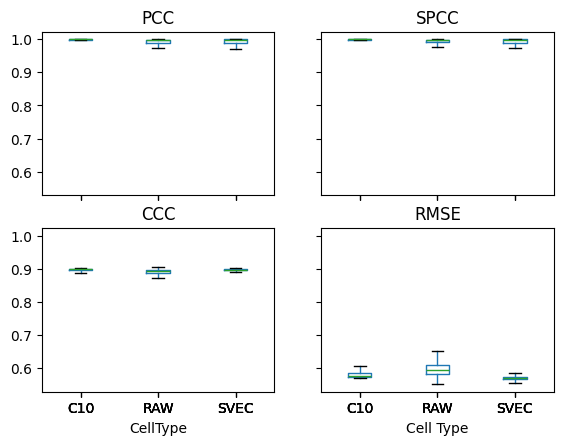

In [128]:
# Assessment of reconstructing cell-type proteomic profiles by Spatial-DC from representative synthetic NSCLC data
# Box plot of metrics for each cell type
plot_df = pd.DataFrame({
    "CellType": ct_orders_list,
    "PCC": total_pcc,
    "SPCC": total_spcc,
    "CCC": total_ccc,
    "RMSE": total_rmse
})

plt.figure(figsize=(10, 8))

boxplot = plot_df.boxplot(column=['PCC', 'SPCC', 'CCC', 'RMSE'], by='CellType', grid=False,showfliers=False)

plt.suptitle('')
plt.xlabel('Cell Type')
plt.ylabel('Metric Value')

plt.show()